In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import linalg
import scipy.optimize as optim

In [2]:
#model parameters
r=0.03 #interest rate
mu=0.07 #average return
sigma=0.3 #volatility
lam_1=1
lam_2=1
down_jump=-0.1
up_jump=0.1
T=.2 #terminal time
c1=1.2 #terminal utility parameter1
c2=0 #terminal utility parameter2
xref=1 #terminal utility parameter3
gamma=0.5 #risk aversion
d=-2 #lower bound of strategy
u=2 #upper bound of strategy

In [3]:
#parameter for the numerical algorithm
zmin=0 #lower bound of the region
zmax=2 # upper bound of the region
Nt=1001 # number of point in t-coordinate
Nz=1001# number of points in z-coordinate
Npi=401 # number of points in control region
z=np.linspace(zmin,zmax,Nz) 
t=np.linspace(0,T,Nt)
pi=np.linspace(d,u,Npi)
dt=t[1]-t[0]
dz=z[1]-z[0]
dpi=pi[1]-pi[0]
#extend z interval
zomax=2*(1+up_jump*u)*zmax-zmax
Nzo=np.ceil(zomax/dz).astype(int)
zomax=Nzo*dz
zo=np.append(z,np.arange(Nz,Nzo)*dz)
pin=np.arange(Nz)
pout=np.arange(Nz,Nzo)

In [4]:
vfull=np.zeros(shape=(Nt,Nzo))#value function
pifull=np.zeros(shape=(Nt,Nzo))#optimal strategy

In [5]:
#terminal condition
eta=mu-r
v=zo**(1-gamma)/(1-gamma)*(zo<xref)+(c1*zo**(1-gamma)/(1-gamma)+c2)*(zo>=xref)
# boundary condition
bounds=optim.Bounds(d,u)
def f(x):
    return -(mu-r)*(1-gamma)*x+0.5*sigma**2*x**2*gamma*(1-gamma)-lam_1*((1+down_jump*x)**(1-gamma)-1)-lam_2*((1+up_jump*x)**(1-gamma)-1)
res=optim.minimize(f,np.array([d]),bounds=bounds)# numerically solve
AA=-1*res['fun']
bmin=zmin**(1-gamma)/(1-gamma)*np.exp(AA*(T-t))
bmax=c1*zomax**(1-gamma)/(1-gamma)*np.exp(AA*(T-t))+c2
vfull[-1,:]=v
vfull[:,0]=bmin
vfull[:,-1]=bmax

In [6]:
#construction of matrix of local operator for every control value pi
A={}
for i in range(len(pi)):
    b=pi[i]*zo*(mu-r)/dz/2
    a=pi[i]**2*zo**2*sigma**2/2/dz/dz
    alpha=(a-b)*(a>=b)+a*(a<b) #backward point
    beta=(a+b)*(a>=b)+(a+2*b)*(a<b)# forward point
    alpha[0]=0
    alpha[-1]=0
    beta[0]=0
    beta[-1]=0
    p = np.arange(0,Nzo)
    M = sparse.coo_matrix((alpha+beta+1/dt,(p,p)),shape=(Nzo,Nzo))
    M=M+sparse.coo_matrix((-1*beta[:-1],(p[:-1],p[:-1]+1)),shape=(Nzo,Nzo))
    M=M+sparse.coo_matrix((-1*alpha[1:],(p[1:],p[1:]-1)),shape=(Nzo,Nzo))
    M=M.tocsc()
    A[i]=M

In [7]:
#construction of matrix of nonlocal operator for every control value pi
downB={}
for i in range(len(pi)):
    z_after=(1+down_jump*pi[i])*z
    #z_after=np.clip(z_after,zmin,zmax)
    lindex=np.floor(z_after/dz)
    zleft=lindex*dz
    rindex=np.ceil(z_after/dz)
    zright=rindex*dz
    lweight=(z_after-zleft)/dz*(zleft<zright)+0.5*(zleft==zright)
    rweight=(zright-z_after)/dz*(zleft<zright)+0.5*(zleft==zright)
    p = np.arange(0,Nz)
    M = sparse.coo_matrix((-1*lweight,(p,lindex)),shape=(Nzo,Nzo))
    M=M+sparse.coo_matrix((-1*rweight,(p,rindex)),shape=(Nzo,Nzo))
    M=M+sparse.coo_matrix((np.ones(shape=Nz),(p,p)),shape=(Nzo,Nzo))
    M=M.tocsc()
    downB[i]=M

In [8]:
upB={}
for i in range(len(pi)):
    z_after=(1+up_jump*pi[i])*z
    #z_after=np.clip(z_after,zmin,zmax)
    lindex=np.floor(z_after/dz)
    zleft=lindex*dz
    rindex=np.ceil(z_after/dz)
    zright=rindex*dz
    lweight=(z_after-zleft)/dz*(zleft<zright)+0.5*(zleft==zright)
    rweight=(zright-z_after)/dz*(zleft<zright)+0.5*(zleft==zright)
    p = np.arange(0,Nz)
    M = sparse.coo_matrix((-1*lweight,(p,lindex)),shape=(Nzo,Nzo))
    M=M+sparse.coo_matrix((-1*rweight,(p,rindex)),shape=(Nzo,Nzo))
    M=M+sparse.coo_matrix((np.ones(shape=Nz),(p,p)),shape=(Nzo,Nzo))
    M=M.tocsc()
    upB[i]=M

In [9]:
for t in reversed(range(Nt-1)):
    prev_v=vfull[t+1,:]
    U=np.zeros(shape=(Npi,Nzo))
    for i in range(len(pi)):
        Au=A[i]
        down_Bu=downB[i]
        up_Bu=upB[i]
        w=1/dt*prev_v
        w[0]=1/dt*bmin[t]
        w[-1]=1/dt*bmax[t]
        U[i,:]=sparse.linalg.spsolve(Au+lam_1*down_Bu+lam_2*up_Bu,w)
    v=np.max(U,axis=0)
    index=np.argmax(U,axis=0)
    pifull[t,:]=index*dpi+d
    vfull[t,:]=v
    if t%100==0:
        print(t)

900
800
700
600
500
400
300
200
100
0


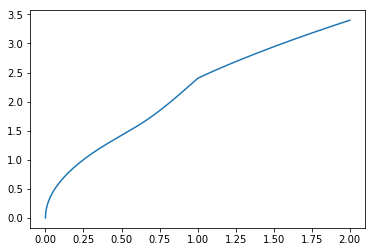

In [10]:
plt.plot(z,vfull[0,:Nz])

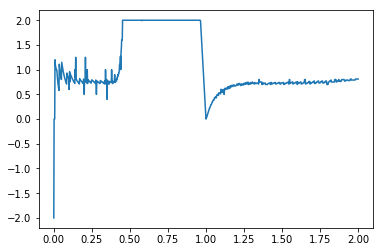

In [11]:
plt.plot(z,pifull[0,:Nz])

In [ ]:
res['x']